In [238]:
import os 
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.signal as ss
from matplotlib import pyplot
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

In [241]:
df = pd.read_csv('C:/Users/ky_moon/Desktop/bigcon/salmon_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120
3,2016-01-18,15.330000,47.386531,38.159864,13.386667,109.228,111.312
4,2016-01-25,19.857103,47.281633,40.924449,12.645000,109.566,111.866


In [242]:
df['DATE']

0      2015-12-28
1      2016-01-04
2      2016-01-11
3      2016-01-18
4      2016-01-25
          ...    
257    2020-11-30
258    2020-12-07
259    2020-12-14
260    2020-12-21
261    2020-12-28
Name: DATE, Length: 262, dtype: object

In [243]:
df.tail()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow
257,2020-11-30,NaN,NaN,NaN,14.542857,116.6540,113.676
258,2020-12-07,NaN,NaN,NaN,14.500000,117.5200,114.614
259,2020-12-14,NaN,NaN,NaN,14.571429,116.4580,113.358
260,2020-12-21,NaN,NaN,NaN,14.864286,115.3480,112.254
261,2020-12-28,NaN,NaN,NaN,15.207143,116.5025,113.345


In [244]:
test_data.tail()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow
257,2020-11-30,NaN,NaN,NaN,14.542857,116.6540,113.676
258,2020-12-07,NaN,NaN,NaN,14.500000,117.5200,114.614
259,2020-12-14,NaN,NaN,NaN,14.571429,116.4580,113.358
260,2020-12-21,NaN,NaN,NaN,14.864286,115.3480,112.254
261,2020-12-28,NaN,NaN,NaN,15.207143,116.5025,113.345


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DATE           262 non-null    object 
 1   WIND_SPEED     230 non-null    float64
 2   SEA_SURF_TEMP  230 non-null    float64
 3   AIR_TEMP       230 non-null    float64
 4   P_PRICE        262 non-null    float64
 5   Broad          262 non-null    float64
 6   Narrow         262 non-null    float64
dtypes: float64(6), object(1)
memory usage: 14.5+ KB


In [246]:
# 결측치 내삽, 계절성이 없는 데이터의 경우 linear method만 사용
ts = df.copy()
ts['DATE'] = pd.to_datetime(ts['DATE'])
ts = ts[['DATE', 'WIND_SPEED', 'SEA_SURF_TEMP', 'AIR_TEMP']]
ts = ts.set_index('DATE')
ts_intp = (ts.interpolate('linear', axis = 0) + ts.interpolate('quadratic', axis = 0) + ts.interpolate('cubic', axis = 0))/3
# 결측치 대치 대상 변수
intp_variable = [['WIND_SPEED', 'SEA_SURF_TEMP', 'AIR_TEMP']]

ts = ts_intp

In [247]:
df['WIND_SPEED'] = list(ts['WIND_SPEED'].values)
df['SEA_SURF_TEMP'] = list(ts['SEA_SURF_TEMP'].values)
df['AIR_TEMP'] = list(ts['AIR_TEMP'].values)

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DATE           262 non-null    object 
 1   WIND_SPEED     232 non-null    float64
 2   SEA_SURF_TEMP  232 non-null    float64
 3   AIR_TEMP       232 non-null    float64
 4   P_PRICE        262 non-null    float64
 5   Broad          262 non-null    float64
 6   Narrow         262 non-null    float64
dtypes: float64(6), object(1)
memory usage: 14.5+ KB


In [249]:
test_data.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow
210,2020-01-06,26.740816,46.253061,42.972109,16.994000,113.618,111.646
211,2020-01-13,20.370852,46.189116,43.171588,17.340000,113.978,112.486
212,2020-01-20,25.564932,46.239796,40.979687,15.586667,113.504,111.910
213,2020-01-27,18.184592,46.051429,40.331497,16.893333,112.056,110.290
214,2020-02-03,17.063039,45.943810,40.187143,15.976667,112.180,110.204


#### 연어 가격 동향 조사

In [250]:
date_index = {}
for idx, date in enumerate(df['DATE']):
    date = str(date)
    year = str(date)[:4] ; month = date[5:7]
    ym = year + '-' + month
    if month == '12':
        if ym not in list(date_index.values()):
            date_index[idx] = ym
            
date_index

{0: '2015-12',
 49: '2016-12',
 101: '2017-12',
 153: '2018-12',
 205: '2019-12',
 258: '2020-12'}

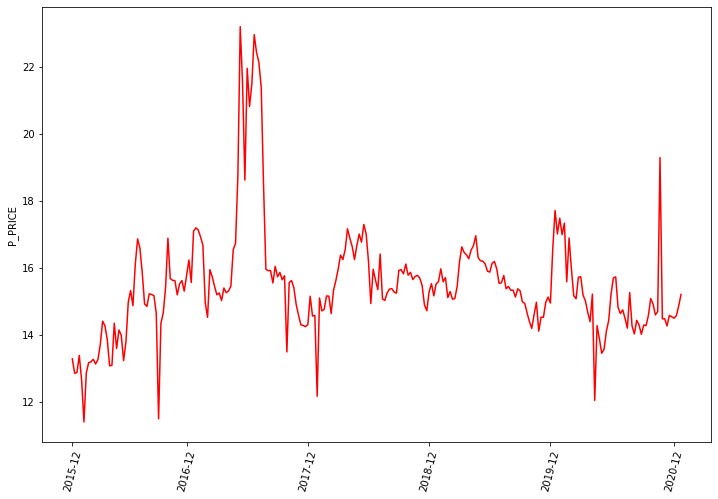

In [251]:
sns.lineplot(data=df['P_PRICE'], color = 'red')
plt.xticks(list(date_index.keys()), list(date_index.values()), rotation=75)
plt.show()

* 17년도 중반에 급격한 가격 상승, 17년도 중반을 제외하면 정상성을 보이는 것 같기도 함

### 시계열 분석

#### 시계열 분해

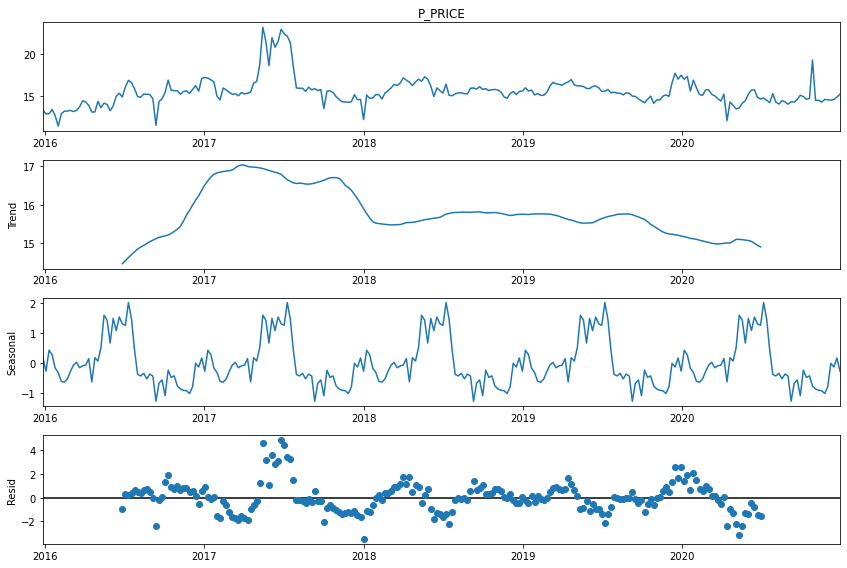

In [295]:
df1 = df.copy()
df1['DATE'] = df1['DATE'].apply(lambda s: datetime.strptime(s, "%Y-%m-%d") ) # 문장열을 datetime객체로
df1 = df1.set_index('DATE')

df1.index = pd.date_range(start=df1.index[0], end=df1.index[-1], freq='7D')

result = seasonal_decompose(df1['P_PRICE'], model='additive')

plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

* 정상 시계열로 보기엔 추세, 계절성, 잔차 모두 유의미한 패턴이 존재함

#### ACF, PACF

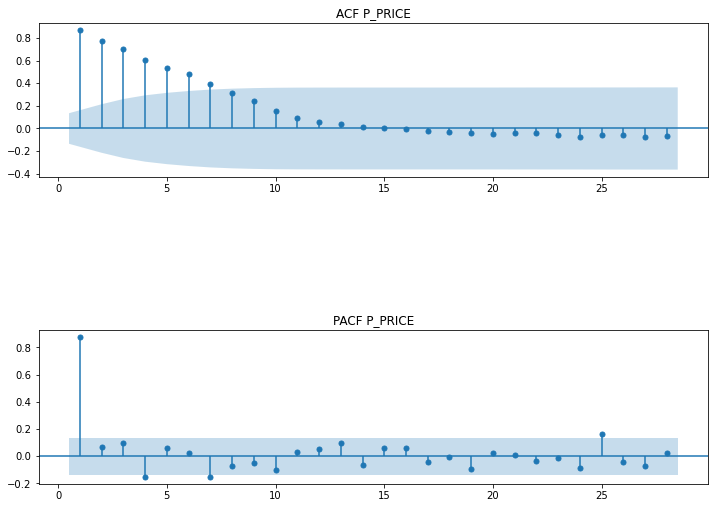

In [83]:
acf_variable = 'P_PRICE'

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df1[acf_variable], lags = 28, zero = False, ax=ax1)
ax1.set_title("ACF " + acf_variable)


sgt.plot_pacf(df1[acf_variable], lags = 28, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF " + acf_variable)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()

* ACF, PACF상에서는 정상 시계열로도 판단이 가능할 수도 있음
  * 통계적 검정 필요

#### ADF Test : 시계열이 안정적(stationary)인지

In [84]:
def adf_test(df) :
    result = adfuller(df.values)
    print('ADF statistics : %f' % result[0])
    print('P-value : %f' % result[1])
    print('Critical values :')
    for k, v in result[4].items():
        print('\t%s : %.3f' % (k, v))
        
# 대상 변수
adf_variable = 'P_PRICE'
print('adf result')
print('variable : ' + adf_variable)
adf_test(df1[adf_variable])

adf result
variable : P_PRICE
ADF statistics : -3.412742
P-value : 0.010532
Critical values :
	1% : -3.462
	5% : -2.876
	10% : -2.574


null : 비정상 시계열
- 기각 실패 : 비정상 시계열 / 기각 : 정상 시계열
  
* p_value값이 애매, 기각역 설정에 따라 결과가 달라짐
* 17년도 중반을 제외하면 정상성을 띄는 것으로도 볼 수 있기 때문에 발생하는 결과?

#### KPSS Test : 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 

In [85]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df) :
    result = kpss(df.values)
    print('KPSS statistics : %f' % result[0])
    print('P-value : %f' % result[1])
    print('# of lags : %f' % result[2])
    print('Critical values :')
    for k, v in result[3].items():
        print('\t%s : %.3f' % (k, v))

# 대상 변수
kpss_variable = 'P_PRICE'
print('kpss result')
print('variable : ' + kpss_variable)
adf_test(df1[kpss_variable])

kpss result
variable : P_PRICE
ADF statistics : -3.412742
P-value : 0.010532
Critical values :
	1% : -3.462
	5% : -2.876
	10% : -2.574


null : 비정상 시계열
* 기각 실패 : 비정상 시계열 / 기각 : 정상 시계열

* p_value=0.01이라 기각역을 어떻게 설정하느냐에 따라 판단 달라짐

####  변수 확인 : 실효환율

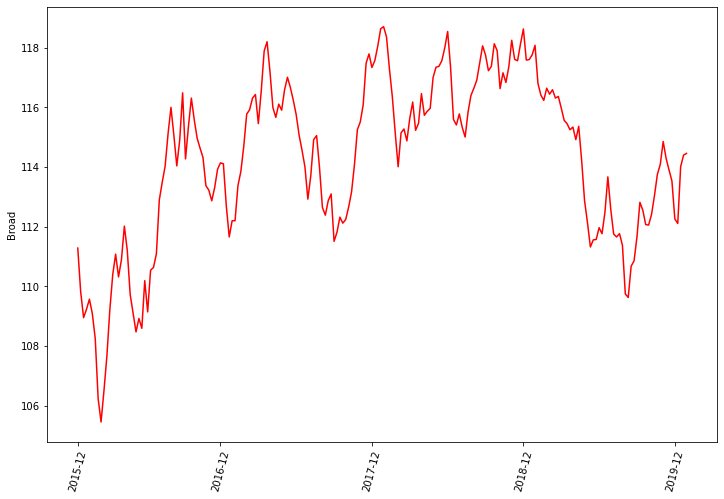

In [86]:
sns.lineplot(data=df['Broad'], color='red')
plt.xticks(list(date_index.keys()), list(date_index.values()), rotation=75)
plt.show()

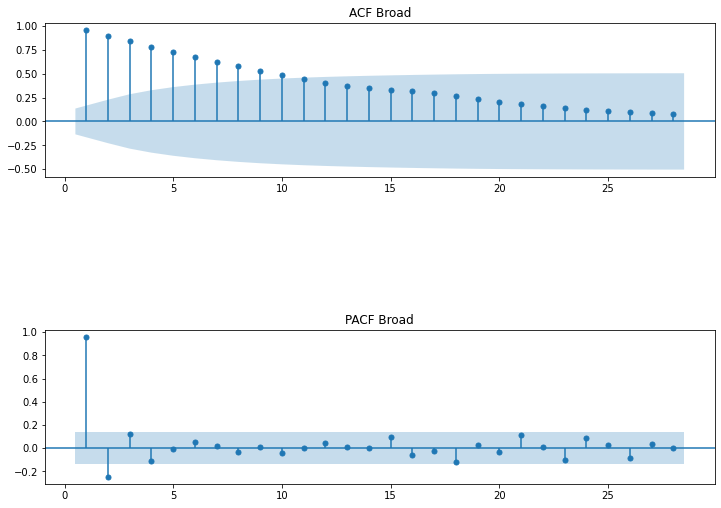

In [87]:
acf_variable = 'Broad'

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df1[acf_variable], lags = 28, zero = False, ax=ax1)
ax1.set_title("ACF " + acf_variable)


sgt.plot_pacf(df1[acf_variable], lags = 28, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF " + acf_variable)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()

In [88]:
adf_variable = 'Broad'
print('adf result')
print('variable : ' + adf_variable)
adf_test(df[adf_variable])

adf result
variable : Broad
ADF statistics : -2.812455
P-value : 0.056517
Critical values :
	1% : -3.462
	5% : -2.876
	10% : -2.574


* 실효 환율은 비정상 시계열

#### 변수 확인 : 수온

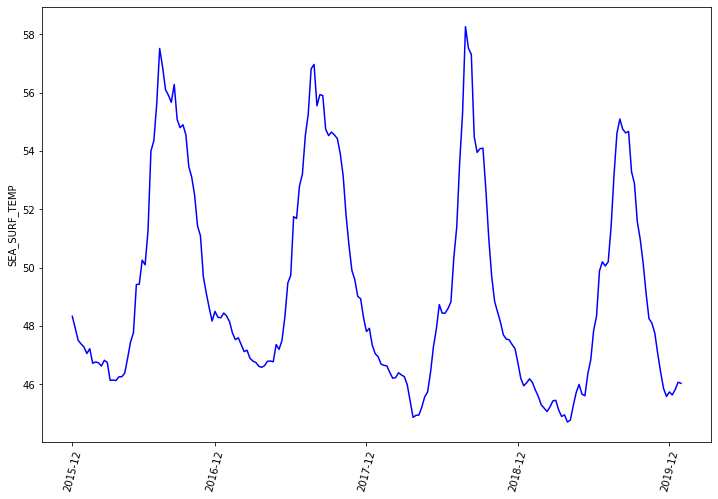

In [89]:
sns.lineplot(data=df['SEA_SURF_TEMP'], color='blue')
plt.xticks(list(date_index.keys()), list(date_index.values()), rotation=75)
plt.show()

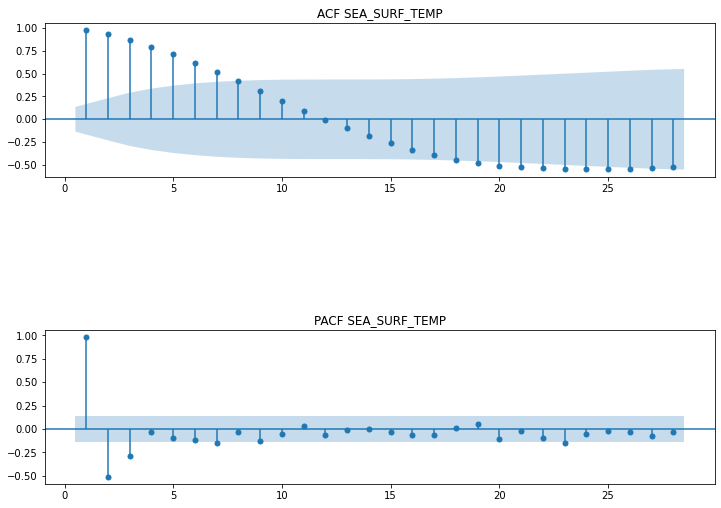

In [90]:
acf_variable = 'SEA_SURF_TEMP'

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df1[acf_variable], lags = 28, zero = False, ax=ax1)
ax1.set_title("ACF " + acf_variable)


sgt.plot_pacf(df1[acf_variable], lags = 28, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF " + acf_variable)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()

In [91]:
adf_variable = 'SEA_SURF_TEMP'
print('adf result')
print('variable : ' + adf_variable)
adf_test(df[adf_variable])

adf result
variable : SEA_SURF_TEMP
ADF statistics : -4.355615
P-value : 0.000355
Critical values :
	1% : -3.463
	5% : -2.876
	10% : -2.574


#### 변수 확인 : 풍속

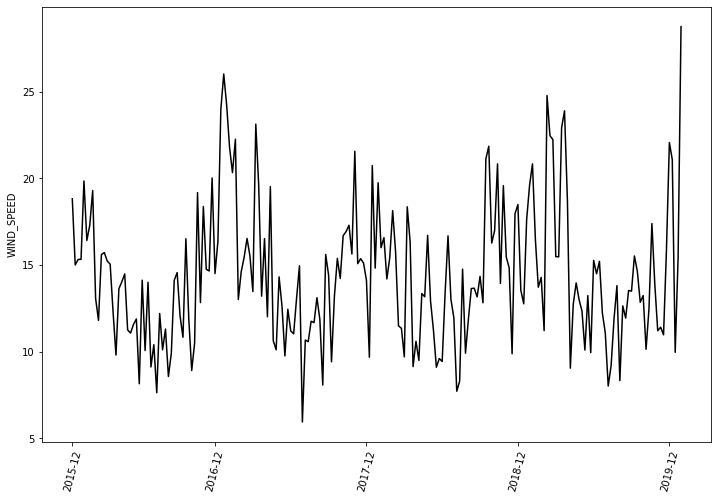

In [92]:
sns.lineplot(data=df['WIND_SPEED'], color='black')
plt.xticks(list(date_index.keys()), list(date_index.values()), rotation=75)
plt.show()

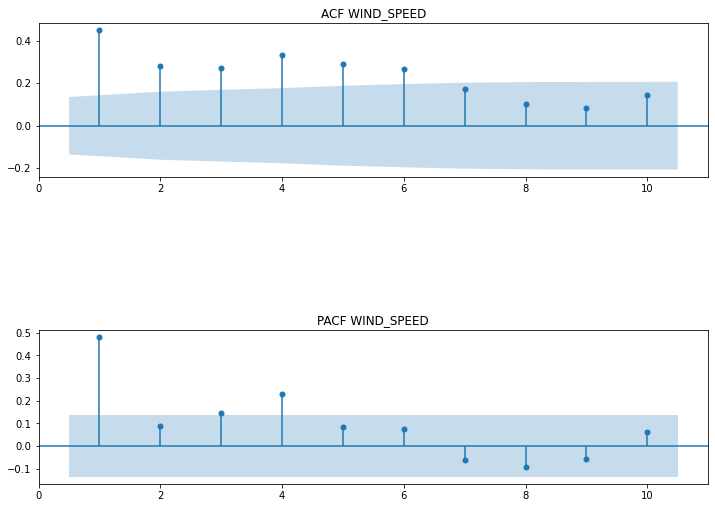

In [93]:
acf_variable = 'WIND_SPEED'

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df1[acf_variable], lags = 10, zero = False, ax=ax1)
ax1.set_title("ACF " + acf_variable)


sgt.plot_pacf(df1[acf_variable], lags = 10, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF " + acf_variable)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()

In [94]:
adf_variable = 'WIND_SPEED'
print('adf result')
print('variable : ' + adf_variable)
adf_test(df[adf_variable])

adf result
variable : WIND_SPEED
ADF statistics : -3.669017
P-value : 0.004571
Critical values :
	1% : -3.462
	5% : -2.876
	10% : -2.574


#### 변수 확인 : 기온

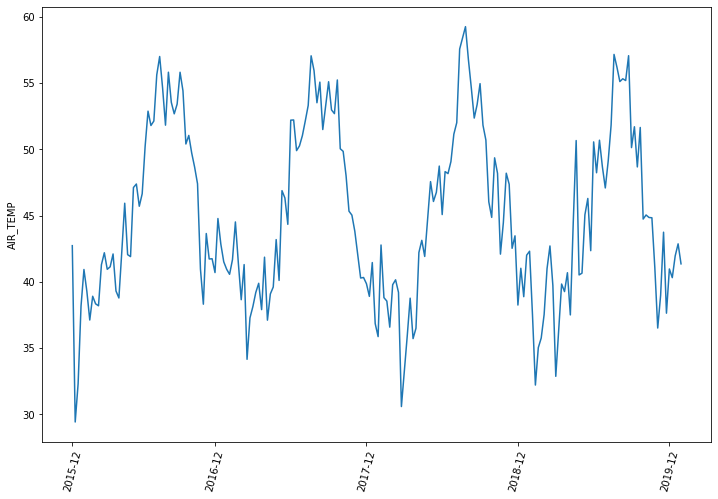

In [95]:
sns.lineplot(data=df['AIR_TEMP'])
plt.xticks(list(date_index.keys()), list(date_index.values()), rotation=75)
plt.show()

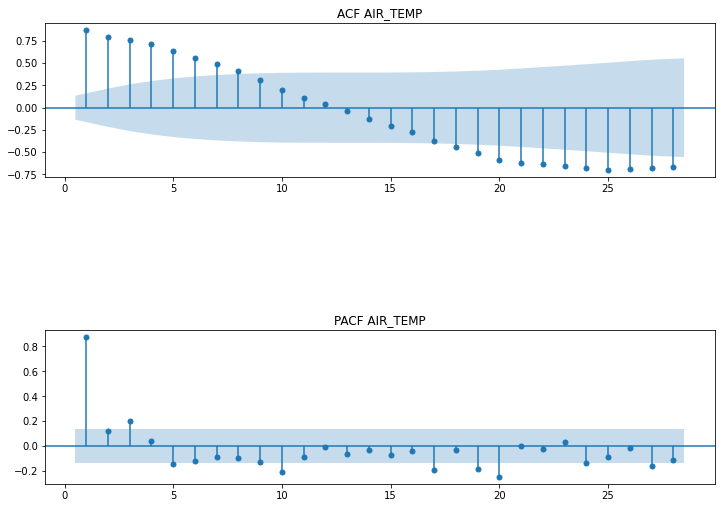

In [96]:
acf_variable = 'AIR_TEMP'

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df1[acf_variable], lags = 28, zero = False, ax=ax1)
ax1.set_title("ACF " + acf_variable)


sgt.plot_pacf(df1[acf_variable], lags = 28, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF " + acf_variable)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()

In [97]:
adf_variable = 'AIR_TEMP'
print('adf result')
print('variable : ' + adf_variable)
adf_test(df[adf_variable])

adf result
variable : AIR_TEMP
ADF statistics : -4.629764
P-value : 0.000114
Critical values :
	1% : -3.464
	5% : -2.876
	10% : -2.575


#### 변수 상관 분석 : CCF


* 여러 시계열 간의 관계를 파악, 시계열간의 선행(lead), 후행(lag)관계가 존재하는 지 파악
   - 실업률 증가 3개월 후 주택 가격이 하락 (주택 가격은 실업률의 후행 지표)
   - 실업률 급증 한 달 전에 대중교통 수요가 증가 (대중교통 수요는 실업률의 선행지표)
   
   
* 선행지표는 특정 시계열의 예측변수, 후행 지표는 관련된 정책 수립등에 이용될 수 있음

* (y_t, x_t) : y_t가 x-계열의 과거 시차와 관계될 수 있음
  - y_t의 예측에 유용하게 사용될 수 있는 x-변수의 시차(lags)를 찾는데 유용
  
  
  
* x_t+h가 y_t의 예측변수로 사용되고 h가 음수 : x leads y
* x_t+h가 y_t의 예측변수로 사용되고 h가 양수 : x lags y


* 계절성으로 인한 허구적 상관성에 유의 (차분윽ㄹ 통해 두 계열간의 순수한 선형적 연관을 확인할 수 있음)

In [98]:
def ccf_udf(x, y, lag_max):

    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

#### (가격, 실효환율)

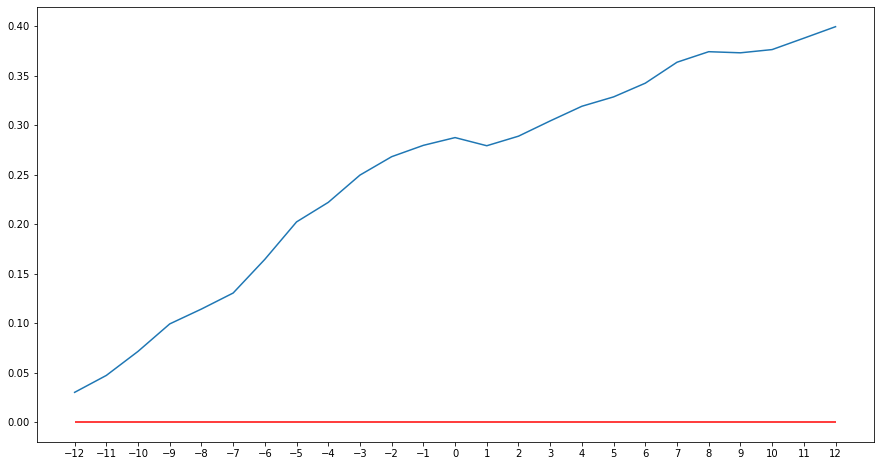

In [99]:
lag_max = 12

ccf_x_variable = 'Broad'
ccf_y_variable = 'P_PRICE'

plt.figure(figsize = (15,8))
plt.plot(list(range(-lag_max, lag_max+1)), list(ccf_udf(df[ccf_x_variable], df[ccf_y_variable], lag_max = lag_max)))
plt.hlines(y = 0, xmin = -lag_max, xmax = lag_max, color = 'red')
plt.xticks(list(range(-lag_max, lag_max+1)))
plt.show()

# ccf : correlation(x(t), y(t+k))

#### (가격, 수온)

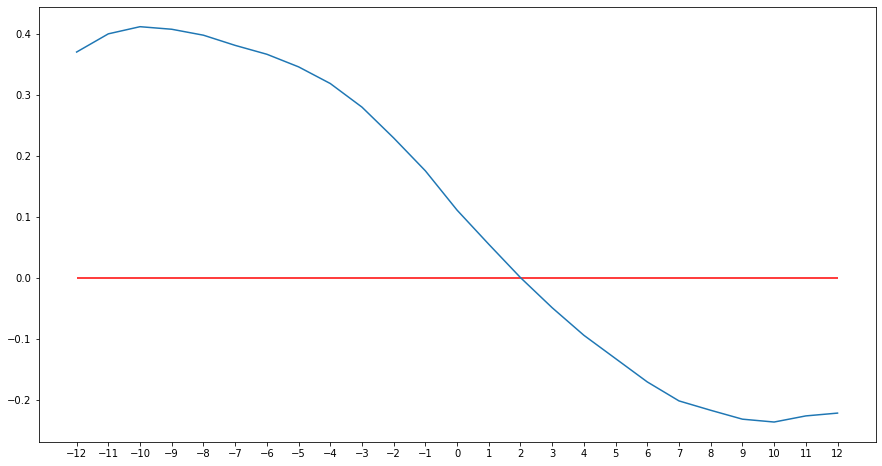

In [100]:
lag_max = 12

ccf_x_variable = 'SEA_SURF_TEMP'
ccf_y_variable = 'P_PRICE'

plt.figure(figsize = (15,8))
plt.plot(list(range(-lag_max, lag_max+1)), list(ccf_udf(df[ccf_x_variable], df[ccf_y_variable], lag_max = lag_max)))
plt.hlines(y = 0, xmin = -lag_max, xmax = lag_max, color = 'red')
plt.xticks(list(range(-lag_max, lag_max+1)))
plt.show()

# ccf : correlation(x(t), y(t+k))

#### (가격, 풍속)

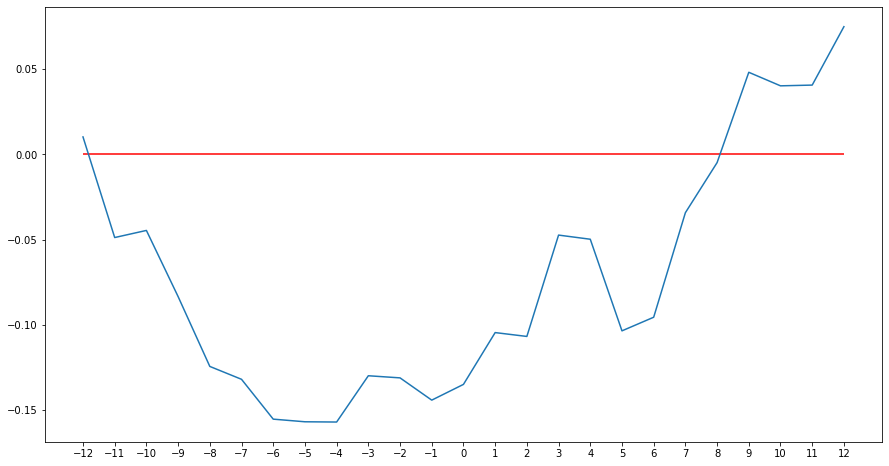

In [101]:
lag_max = 12

ccf_x_variable = 'WIND_SPEED'
ccf_y_variable = 'P_PRICE'

plt.figure(figsize = (15,8))
plt.plot(list(range(-lag_max, lag_max+1)), list(ccf_udf(df[ccf_x_variable], df[ccf_y_variable], lag_max = lag_max)))
plt.hlines(y = 0, xmin = -lag_max, xmax = lag_max, color = 'red')
plt.xticks(list(range(-lag_max, lag_max+1)))
plt.show()

# ccf : correlation(x(t), y(t+k))

#### (가격, 기온)

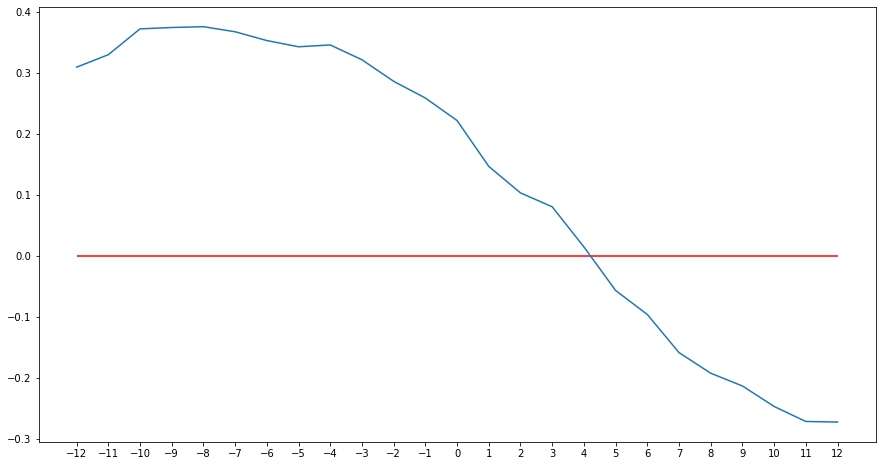

In [102]:
lag_max = 12

ccf_x_variable = 'AIR_TEMP'
ccf_y_variable = 'P_PRICE'

plt.figure(figsize = (15,8))
plt.plot(list(range(-lag_max, lag_max+1)), list(ccf_udf(df[ccf_x_variable], df[ccf_y_variable], lag_max = lag_max)))
plt.hlines(y = 0, xmin = -lag_max, xmax = lag_max, color = 'red')
plt.xticks(list(range(-lag_max, lag_max+1)))
plt.show()

# ccf : correlation(x(t), y(t+k))

#### 그래인저 인과 검정


* 동일한 시간축의 범위를 가진 두 데이터가 있을 때 한 데이터를 다른 한쪽 데이터의 특정한 시간 간격에 대해 선형 회귀가 가능하면 그래인저 인과관계가 존재


* 정상성 가정 필요

In [103]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset

dataset = df

grangers_causality_matrix(dataset, variables = dataset.columns[1:])

,WIND_SPEED_x,SEA_SURF_TEMP_x,AIR_TEMP_x,P_PRICE_x,Broad_x,Narrow_x
WIND_SPEED_y,1.0000,0.0281,0.0021,0.2373,0.3034,0.4416
SEA_SURF_TEMP_y,0.0000,1.0000,0.0000,0.0000,0.0602,0.2926
AIR_TEMP_y,0.0000,0.0000,1.0000,0.0539,0.0658,0.0511
P_PRICE_y,0.0542,0.1572,0.0263,1.0000,0.0767,0.2524
Broad_y,0.4906,0.0103,0.3569,0.1106,1.0000,0.1140
Narrow_y,0.2290,0.0212,0.4503,0.2977,0.1429,1.0000


#### fbprophet

In [296]:
# 모델 생성
from fbprophet import Prophet

df2 = df.copy()
df2 = df2[['DATE', 'P_PRICE']]
df2['DATE'] = pd.to_datetime(df2['DATE'])
df2.columns = ['ds', 'y']

model = Prophet()
model.daily_seasonality=True

model.fit(df2)

In [253]:
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2020-%02d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

In [37]:
forecast = model.predict(last_1year)

In [38]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2020-01-01  15.976668   14.467476   17.467901
1 2020-02-01  15.420832   13.825875   16.874424
2 2020-03-01  16.763008   15.331235   18.340751
3 2020-04-01  16.552638   14.992796   18.084036
4 2020-05-01  17.373401   15.810598   18.947531


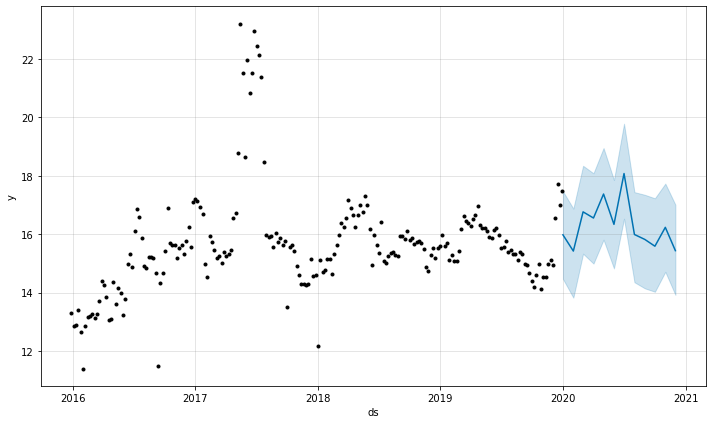

In [39]:
model.plot(forecast)
pyplot.show()

####  학습&예측

In [297]:
df3 = df.copy()
df3 = df3[['DATE', 'P_PRICE']]
df3['DATE'] = pd.to_datetime(df3['DATE'])
df3.columns = ['ds', 'y']

model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True)

model.fit(df3)

In [298]:
last_1year = test_data[['DATE']]  # 2020년도 데이터를 예측
last_1year.columns=['ds']

In [299]:
last_1year.head()

,ds
210,2020-01-06
211,2020-01-13
212,2020-01-20
213,2020-01-27
214,2020-02-03


In [300]:
forecast = model.predict(last_1year)

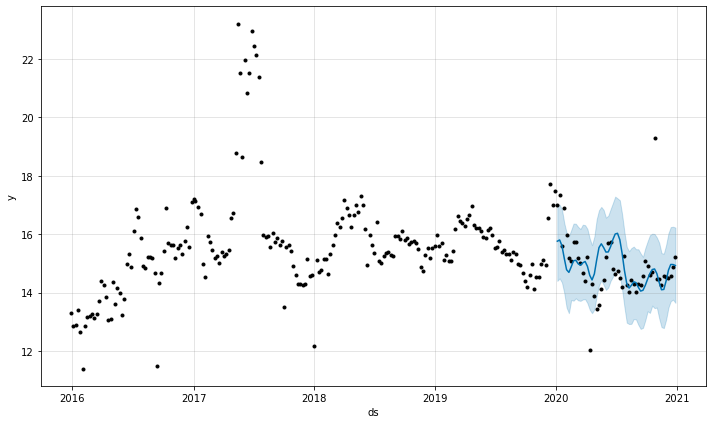

In [301]:
model.plot(forecast)
pyplot.show()

In [127]:
test_set = test_data[['DATE',  'P_PRICE']].copy()
predicted = forecast[['yhat']]
test_set['predicted'] = list(predicted['yhat'])

In [128]:
test_set.head()

,DATE,P_PRICE,predicted
210,2020-01-06,16.994000,15.736055
211,2020-01-13,17.340000,15.728518
212,2020-01-20,15.586667,15.574979
213,2020-01-27,16.893333,15.217709
214,2020-02-03,15.976667,14.871296


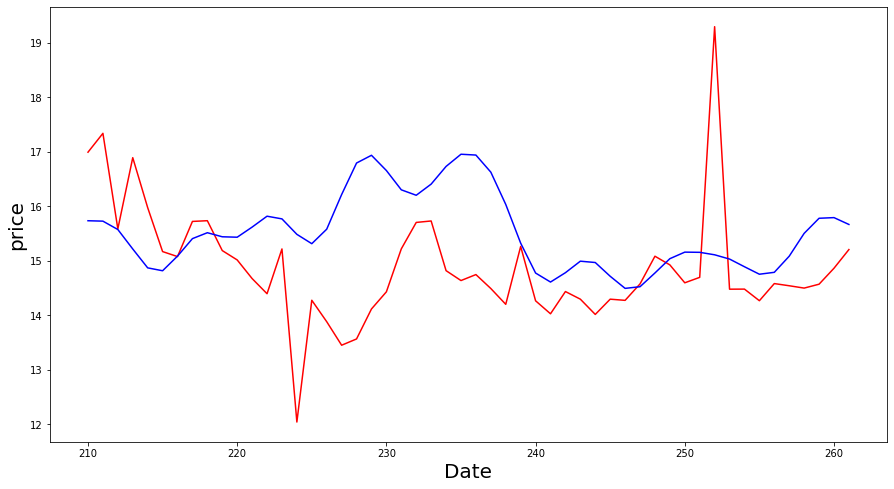

In [131]:
plt.figure(figsize = (15,8))
sns.lineplot(data=test_set['P_PRICE'], color = 'red')
sns.lineplot(data=test_set['predicted'], color = 'blue')
plt.ylabel('price', size=20)
plt.xlabel('Date', size=20)
plt.show()

In [132]:
sse = 0
for i in range(len(test_set)):
    real = test_set.iloc[i, :]['P_PRICE']
    pred = test_set.iloc[i, :]['predicted']
    se = (pred - real)**2
    sse += se
mse = sse / test_set.shape[0]
mse

2.066973459885666

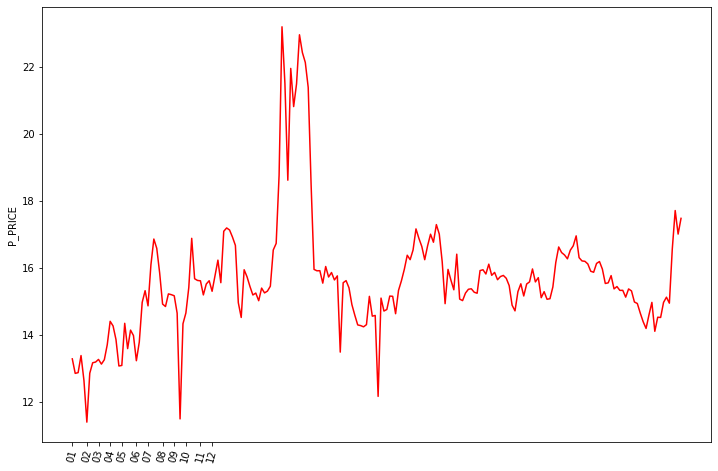

In [133]:
sns.lineplot(data=df['P_PRICE'], color = 'red')
plt.xticks(list(date_index.keys()), list(date_index.values()), rotation=75)
plt.show()

* 17년도 중반 데이터 : outlier

#### 17년도 데이터 관찰하기

In [254]:
df['year'] = df['DATE'].apply(lambda s: s[:4])
df_17 = df.loc[df['year']=='2017']
df_17.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year
53,2017-01-01,24.237091,48.341721,40.942759,17.198333,112.198,113.062,2017
54,2017-01-06,21.788311,48.146807,40.561409,17.136667,112.198,113.062,2017
55,2017-01-16,20.338095,47.757143,41.670748,16.925000,113.376,113.832,2017
56,2017-01-23,22.264626,47.532653,44.514966,16.676667,113.852,114.150,2017
57,2017-01-30,13.010238,47.597143,41.447818,14.966667,114.698,114.920,2017


In [255]:
date_index = {}
for idx, date in enumerate(df_17['DATE']):
    month = date[5:7]
    if month not in list(date_index.values()):
        date_index[idx] = month
            
date_index

{0: '01',
 5: '02',
 9: '03',
 13: '04',
 17: '05',
 22: '06',
 26: '07',
 31: '08',
 35: '09',
 39: '10',
 44: '11',
 48: '12'}

In [256]:
df_17.index = df_17.index - 53

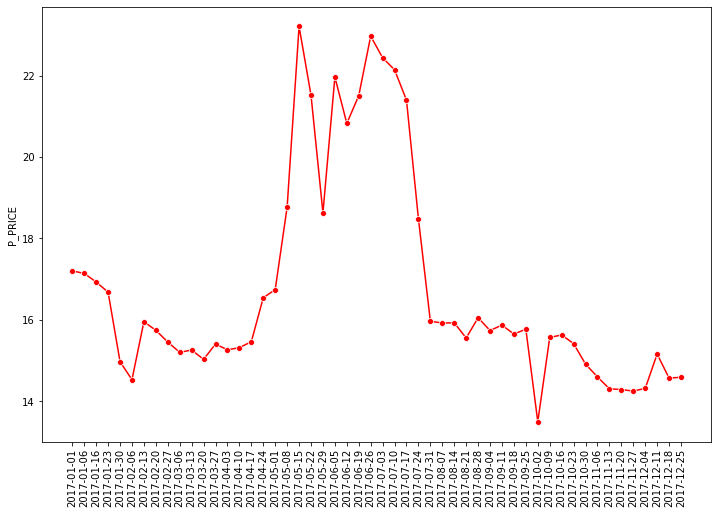

In [257]:
sns.lineplot(data=df_17['P_PRICE'], color = 'red', marker='o')
plt.xticks(list(df_17.index), list(df_17.DATE), rotation=90)
plt.show()

#### 이상치 기준 설정

In [302]:
Q1 = np.percentile(df['P_PRICE'], 25) 
Q3 = np.percentile(df['P_PRICE'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR

In [303]:
cond = df['P_PRICE'] > Q3 + outlier_step
df.loc[cond][['DATE', 'P_PRICE']]

,DATE,P_PRICE
71,2017-05-08,18.766667
72,2017-05-15,23.206667
73,2017-05-22,21.516667
74,2017-05-29,18.624286
75,2017-06-05,21.963333
76,2017-06-12,20.823333
77,2017-06-19,21.505000
78,2017-06-26,22.968000
79,2017-07-03,22.436667
80,2017-07-10,22.141667


In [260]:
df_revised = df.copy()

In [261]:
outliers = list(df.loc[cond].index)
for idx in outliers:
    df_revised.iloc[idx, 4] = np.nan  # 내삽하고자 하는 부분에 강제적으로 결측치 할당

In [262]:
df_revised.loc[cond]

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year
71,2017-05-08,14.318333,47.200000,40.099286,NaN,116.584,116.828,2017
72,2017-05-15,12.634286,47.507143,46.877143,NaN,117.010,116.922,2017
73,2017-05-22,9.756190,48.321429,46.322857,NaN,116.664,116.360,2017
74,2017-05-29,12.452857,49.475000,44.334286,NaN,116.238,116.234,2017
75,2017-06-05,11.200000,49.733333,52.200000,NaN,115.752,115.810,2017
76,2017-06-12,11.035714,51.750000,52.214286,NaN,115.068,115.216,2017
77,2017-06-19,13.078571,51.685714,49.900000,NaN,114.558,114.634,2017
78,2017-06-26,14.961905,52.800000,50.257143,NaN,114.004,114.052,2017
79,2017-07-03,5.942857,53.200000,51.033333,NaN,112.922,112.976,2017
80,2017-07-10,10.671429,54.520000,52.147619,NaN,113.702,113.798,2017


#### 결측치 보간

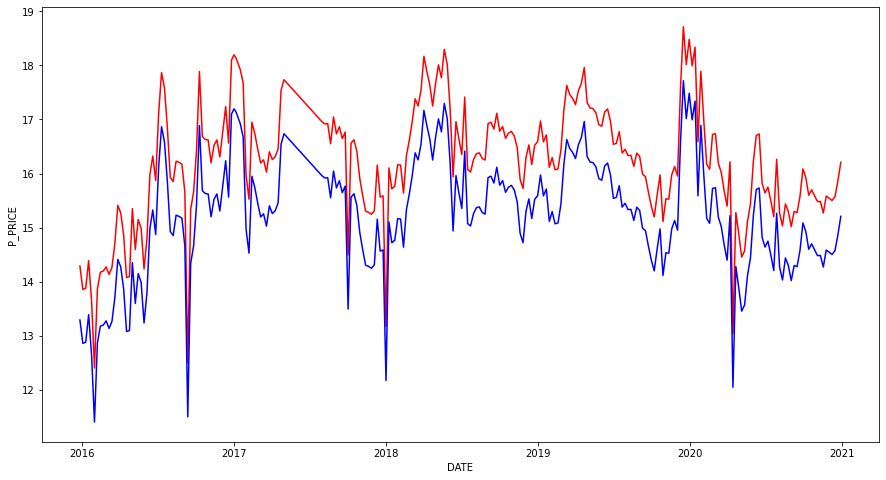

In [263]:
ts = df_revised.copy()
ts['DATE'] = pd.to_datetime(ts['DATE'])
ts = ts[['DATE', 'P_PRICE']]
ts = ts.set_index('DATE')

ts_intp = ts.interpolate('linear', axis=0)

intp_variable = 'P_PRICE'

plt.figure(figsize = (15,8))
sns.lineplot(data = ts[intp_variable] + 1, color = 'red') # 내삽 전
sns.lineplot(data = ts_intp[intp_variable], color = 'blue') # 내삽 후

ts = ts_intp        

In [264]:
ts = ts.reset_index()
ts.head()

,DATE,P_PRICE
0,2015-12-28,13.288000
1,2016-01-04,12.855000
2,2016-01-11,12.876667
3,2016-01-18,13.386667
4,2016-01-25,12.645000


In [265]:
ts[cond] # 내삽 후 변경된 값

,DATE,P_PRICE
71,2017-05-08,16.676923
72,2017-05-15,16.617179
73,2017-05-22,16.557436
74,2017-05-29,16.497692
75,2017-06-05,16.437949
76,2017-06-12,16.378205
77,2017-06-19,16.318462
78,2017-06-26,16.258718
79,2017-07-03,16.198974
80,2017-07-10,16.139231


In [266]:
df[cond] # 내삽 전 original 값

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year
71,2017-05-08,14.318333,47.200000,40.099286,18.766667,116.584,116.828,2017
72,2017-05-15,12.634286,47.507143,46.877143,23.206667,117.010,116.922,2017
73,2017-05-22,9.756190,48.321429,46.322857,21.516667,116.664,116.360,2017
74,2017-05-29,12.452857,49.475000,44.334286,18.624286,116.238,116.234,2017
75,2017-06-05,11.200000,49.733333,52.200000,21.963333,115.752,115.810,2017
76,2017-06-12,11.035714,51.750000,52.214286,20.823333,115.068,115.216,2017
77,2017-06-19,13.078571,51.685714,49.900000,21.505000,114.558,114.634,2017
78,2017-06-26,14.961905,52.800000,50.257143,22.968000,114.004,114.052,2017
79,2017-07-03,5.942857,53.200000,51.033333,22.436667,112.922,112.976,2017
80,2017-07-10,10.671429,54.520000,52.147619,22.141667,113.702,113.798,2017


In [267]:
df_revised = ts
df_revised = df_revised.reset_index()
df_revised = df_revised.drop('index', axis=1)
df_revised['date'] = df_revised['DATE'].apply(lambda s: str(s)[:10])
df_revised.head()

,DATE,P_PRICE,date
0,2015-12-28,13.288000,2015-12-28
1,2016-01-04,12.855000,2016-01-04
2,2016-01-11,12.876667,2016-01-11
3,2016-01-18,13.386667,2016-01-18
4,2016-01-25,12.645000,2016-01-25


In [268]:
df_revised.tail()

,DATE,P_PRICE,date
257,2020-11-30,14.542857,2020-11-30
258,2020-12-07,14.500000,2020-12-07
259,2020-12-14,14.571429,2020-12-14
260,2020-12-21,14.864286,2020-12-21
261,2020-12-28,15.207143,2020-12-28


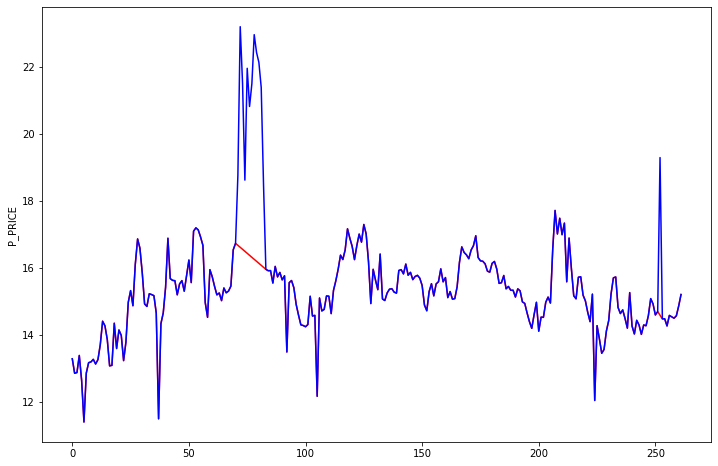

In [269]:
sns.lineplot(data=df_revised['P_PRICE'], color = 'red')
sns.lineplot(data=df['P_PRICE'], color = 'blue')
plt.show()

* 17년도 중반의 스파이크가 완화된 모습

#### 학습&훈련 (내삽으로 수정된 데이터)

In [270]:
df4 = df_revised.copy()
df4 = df4[['DATE', 'P_PRICE']]
df4['DATE'] = pd.to_datetime(df4['DATE'])
df4.columns = ['ds', 'y']

model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=True)

model.fit(df4)

In [271]:
last_1year = test_data[['DATE']]
last_1year.columns=['ds']
last_1year.head()

,ds
210,2020-01-06
211,2020-01-13
212,2020-01-20
213,2020-01-27
214,2020-02-03


In [273]:
df.tail()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year
257,2020-11-30,NaN,NaN,NaN,14.542857,116.6540,113.676,2020
258,2020-12-07,NaN,NaN,NaN,14.500000,117.5200,114.614,2020
259,2020-12-14,NaN,NaN,NaN,14.571429,116.4580,113.358,2020
260,2020-12-21,NaN,NaN,NaN,14.864286,115.3480,112.254,2020
261,2020-12-28,NaN,NaN,NaN,15.207143,116.5025,113.345,2020


In [304]:
future = model.make_future_dataframe(periods=26, freq='w')
future = future[262:]

In [305]:
forecast = model.predict(future)

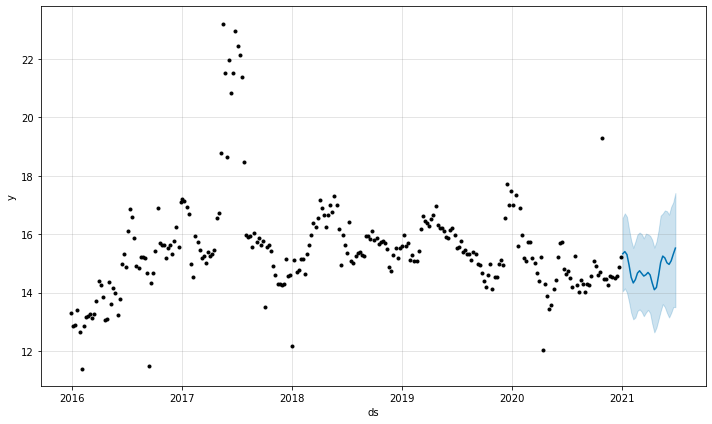

In [306]:
model.plot(forecast)
pyplot.show()

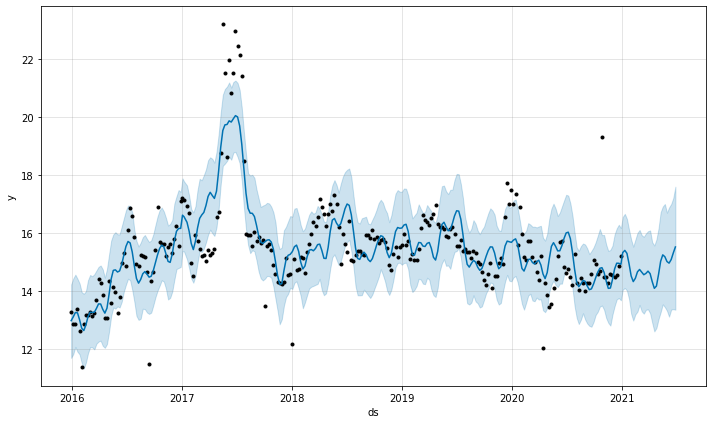

In [309]:
model_all = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=True)

model_all.fit(df4)

future_all = model_all.make_future_dataframe(periods=26, freq='w')
total = model.predict(future_all)
model.plot(total)
pyplot.show()

In [310]:
future

,ds
262,2021-01-03
263,2021-01-10
264,2021-01-17
265,2021-01-24
266,2021-01-31
267,2021-02-07
268,2021-02-14
269,2021-02-21
270,2021-02-28
271,2021-03-07


In [156]:
test_set = test_data[['DATE',  'P_PRICE']].copy()
predicted = forecast[['yhat']]
test_set['yhat'] = list(predicted['yhat'])
test_set.head()

,DATE,P_PRICE,yhat
210,2020-01-06,16.994000,15.620893
211,2020-01-13,17.340000,15.641674
212,2020-01-20,15.586667,15.565524
213,2020-01-27,16.893333,15.313803
214,2020-02-03,15.976667,15.043814


In [157]:
sse = 0
for i in range(len(test_set)):
    real = test_set.iloc[i, :]['P_PRICE']
    pred = test_set.iloc[i, :]['yhat']
    se = (pred - real)**2
    sse += se
mse = sse / test_set.shape[0]
mse

2.0673886078770303

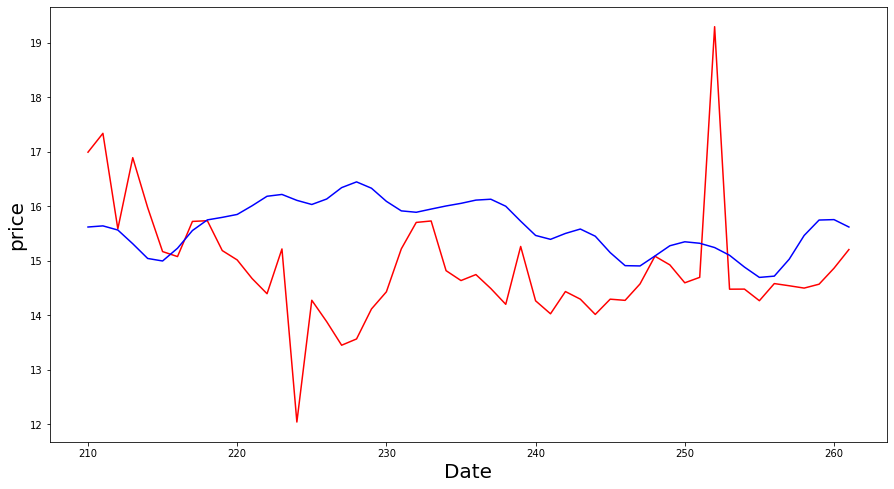

In [158]:
plt.figure(figsize = (15,8))
sns.lineplot(data=test_set['P_PRICE'], color = 'red')
sns.lineplot(data=test_set['yhat'], color = 'blue')
plt.ylabel('price', size=20)
plt.xlabel('Date', size=20)
plt.show()

In [159]:
past = df[['DATE']]
past.columns=['ds']
past.head()

,ds
0,2015-12-28
1,2016-01-04
2,2016-01-11
3,2016-01-18
4,2016-01-25


In [160]:
past_fitted = model.predict(past)

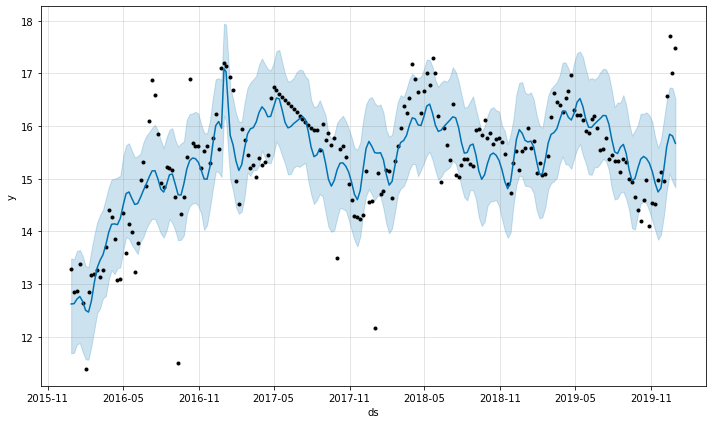

In [165]:
model.plot(past_fitted)
pyplot.show()

In [161]:
df4

,ds,y
0,2015-12-28,13.288000
1,2016-01-04,12.855000
2,2016-01-11,12.876667
3,2016-01-18,13.386667
4,2016-01-25,12.645000
...,...,...
205,2019-12-02,14.951667
206,2019-12-09,16.568333
207,2019-12-16,17.718333
208,2019-12-23,17.015000


In [164]:
df4['yhat'] = past_fitted['yhat']
df4['residual'] = df4['y'] - df4['fitted']

In [163]:
df4.head()

,ds,y,fitted,residual
0,2015-12-28,13.288000,12.624742,0.663258
1,2016-01-04,12.855000,12.630164,0.224836
2,2016-01-11,12.876667,12.716925,0.159742
3,2016-01-18,13.386667,12.766577,0.620090
4,2016-01-25,12.645000,12.670976,-0.025976


In [166]:
df['P_PRICE'] = df4['y']
df['yhat'] = df4['yhat']
df['residual'] = df4['residual']

In [168]:
test_data['yhat'] = list(forecast['yhat'])
test_data['residual'] = test_data['P_PRICE'] - test_data['yhat']

In [169]:
test_data.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,yhat,residual
210,2020-01-06,26.740816,46.253061,42.972109,16.994000,113.618,111.646,15.620893,1.373107
211,2020-01-13,20.370852,46.189116,43.171588,17.340000,113.978,112.486,15.641674,1.698326
212,2020-01-20,25.564932,46.239796,40.979687,15.586667,113.504,111.910,15.565524,0.021143
213,2020-01-27,18.184592,46.051429,40.331497,16.893333,112.056,110.290,15.313803,1.579530
214,2020-02-03,17.063039,45.943810,40.187143,15.976667,112.180,110.204,15.043814,0.932853


In [172]:
test_data.tail() # 20년도 중반 이후 데이터 x : prophet으로 예측 

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,yhat,residual
257,2020-11-30,NaN,NaN,NaN,14.542857,116.6540,113.676,15.030452,-0.487595
258,2020-12-07,NaN,NaN,NaN,14.500000,117.5200,114.614,15.465521,-0.965521
259,2020-12-14,NaN,NaN,NaN,14.571429,116.4580,113.358,15.748799,-1.177370
260,2020-12-21,NaN,NaN,NaN,14.864286,115.3480,112.254,15.756699,-0.892413
261,2020-12-28,NaN,NaN,NaN,15.207143,116.5025,113.345,15.620963,-0.413820


In [173]:
df.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,yhat,residual
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305,2015,12.624742,0.663258
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292,2016,12.630164,0.224836
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120,2016,12.716925,0.159742
3,2016-01-18,15.330000,47.386531,38.159864,13.386667,109.228,111.312,2016,12.766577,0.620090
4,2016-01-25,19.857103,47.281633,40.924449,12.645000,109.566,111.866,2016,12.670976,-0.025976


In [178]:
total = pd.concat([df, test_data]) # total data

In [189]:
wind = total[['DATE', 'WIND_SPEED']]  # 풍속의 결측값 예측
cond = wind['WIND_SPEED'].isnull()

wind_train = wind.loc[~cond][['DATE', 'WIND_SPEED']]
wind_train['DATE'] = pd.to_datetime(wind_train['DATE'])
wind_train.columns = ['ds', 'y']

In [191]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True,
                 weekly_seasonality=True, daily_seasonality=True)

model.fit(wind_train)

In [192]:
wind_test = wind.loc[cond][['DATE', 'WIND_SPEED']]
wind_test['DATE'] = pd.to_datetime(wind_test['DATE'])
wind_test.columns = ['ds', 'y']

In [194]:
wind_forecast = model.predict(wind_test)

In [214]:
wind_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-06-08,22.428185,10.049778,17.665971,22.428185,22.428185,-0.173729,-0.173729,-0.173729,-0.378751,...,-0.130182,-0.130182,-0.130182,-0.074840,-0.074840,-0.074840,0.0,0.0,0.0,13.933480
1,2020-06-15,22.441428,10.618336,18.673988,22.441428,22.441428,-0.173729,-0.173729,-0.173729,-0.352315,...,-0.130182,-0.130182,-0.130182,-0.048404,-0.048404,-0.048404,0.0,0.0,0.0,14.534966
2,2020-06-22,22.454671,9.782503,17.814198,22.454668,22.454674,-0.173729,-0.173729,-0.173729,-0.388046,...,-0.130182,-0.130182,-0.130182,-0.084135,-0.084135,-0.084135,0.0,0.0,0.0,13.741228
3,2020-06-29,22.467914,8.236708,15.822883,22.467906,22.467922,-0.173729,-0.173729,-0.173729,-0.460493,...,-0.130182,-0.130182,-0.130182,-0.156581,-0.156581,-0.156581,0.0,0.0,0.0,12.121604
4,2020-07-06,22.481157,6.682314,14.604449,22.481143,22.481172,-0.173729,-0.173729,-0.173729,-0.522963,...,-0.130182,-0.130182,-0.130182,-0.219052,-0.219052,-0.219052,0.0,0.0,0.0,10.724348


In [198]:
total['WIND_SPEED'][cond] = list(wind_forecast['yhat'])

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



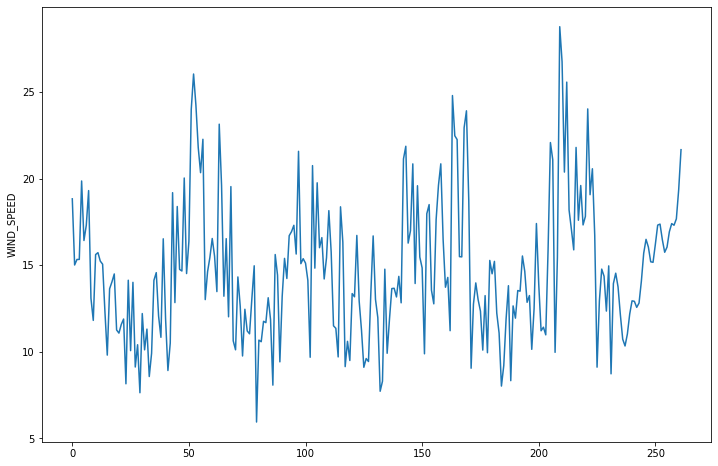

In [217]:
sns.lineplot(data=total['WIND_SPEED'])
plt.show()

In [219]:
air = total[['DATE', 'AIR_TEMP']]  # 풍속의 결측값 예측
cond = air['AIR_TEMP'].isnull()

air_train = air.loc[~cond][['DATE', 'AIR_TEMP']]
air_train['DATE'] = pd.to_datetime(air_train['DATE'])
air_train.columns = ['ds', 'y']

In [220]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True,
                 weekly_seasonality=True, daily_seasonality=True)

model.fit(air_train)

In [221]:
air_test = air.loc[cond][['DATE', 'AIR_TEMP']]
air_test['DATE'] = pd.to_datetime(air_test['DATE'])
air_test.columns = ['ds', 'y']

In [222]:
air_forecast = model.predict(air_test)

In [223]:
wind_forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-06-08,22.428185,10.049778,17.665971,22.428185,22.428185,-0.173729,-0.173729,-0.173729,-0.378751,...,-0.130182,-0.130182,-0.130182,-0.074840,-0.074840,-0.074840,0.0,0.0,0.0,13.933480
1,2020-06-15,22.441428,10.618336,18.673988,22.441428,22.441428,-0.173729,-0.173729,-0.173729,-0.352315,...,-0.130182,-0.130182,-0.130182,-0.048404,-0.048404,-0.048404,0.0,0.0,0.0,14.534966
2,2020-06-22,22.454671,9.782503,17.814198,22.454668,22.454674,-0.173729,-0.173729,-0.173729,-0.388046,...,-0.130182,-0.130182,-0.130182,-0.084135,-0.084135,-0.084135,0.0,0.0,0.0,13.741228


In [224]:
total['AIR_TEMP'][cond] = list(air_forecast['yhat'])

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



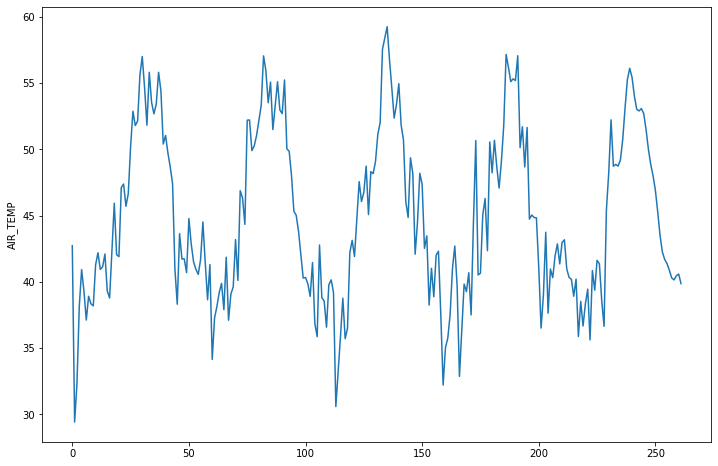

In [225]:
sns.lineplot(data=total['AIR_TEMP'])
plt.show()

In [228]:
var = 'SEA_SURF_TEMP'

sea = total[['DATE', var]]  # 풍속의 결측값 예측
cond = sea[var].isnull()

sea_train = sea.loc[~cond][['DATE', var]]
sea_train['DATE'] = pd.to_datetime(sea_train['DATE'])
sea_train.columns = ['ds', 'y']

In [229]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True,
                 weekly_seasonality=True, daily_seasonality=True)

model.fit(sea_train)

In [231]:
sea_test = sea.loc[cond][['DATE', var]]
sea_test['DATE'] = pd.to_datetime(sea_test['DATE'])
sea_test.columns = ['ds', 'y']

In [232]:
sea_forecast = model.predict(sea_test)

In [233]:
total[var][cond] = list(sea_forecast['yhat'])

C:\Users\ky_moon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



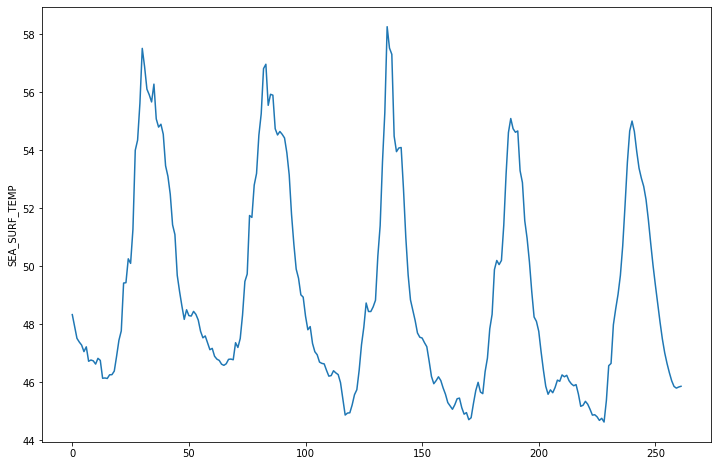

In [234]:
sns.lineplot(data=total[var])
plt.show()

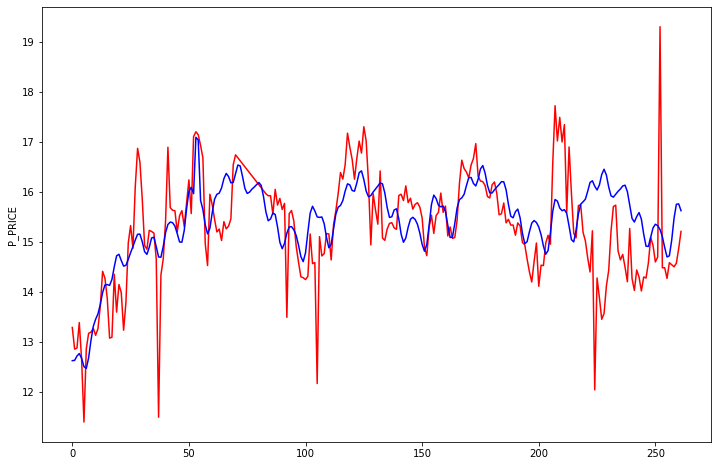

In [235]:
sns.lineplot(data=total['P_PRICE'], color = 'red')
sns.lineplot(data=total['yhat'], color = 'blue')
plt.show()

In [237]:
total.to_csv('C:/Users/ky_moon/Desktop/bigcon/total_fb_res.csv')

In [610]:
df.to_csv('C:/Users/ky_moon/Desktop/bigcon/data_with_residual.csv')

In [612]:
test_data.to_csv('C:/Users/ky_moon/Desktop/bigcon/test_data.csv')

In [616]:
test_data.tail()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,fitted,residual
257,2020-11-30,NaN,NaN,NaN,14.542857,116.6540,113.676,15.152454,-0.609597
258,2020-12-07,NaN,NaN,NaN,14.500000,117.5200,114.614,15.607810,-1.107810
259,2020-12-14,NaN,NaN,NaN,14.571429,116.4580,113.358,15.871019,-1.299590
260,2020-12-21,NaN,NaN,NaN,14.864286,115.3480,112.254,15.800262,-0.935976
261,2020-12-28,NaN,NaN,NaN,15.207143,116.5025,113.345,15.561504,-0.354361
